<h1>OpenModelica Weather data</h1>

The OpenModelica Greenhouse library utilises a number of input files of both environmental conditions and control set points in order to run its simulations. In order to create new data for the model, we must start with a sufficient dataset, containing the environmental variables required. Candidate datasets must include global irradiance, temperature, pressure, relative humidity and wind speed over a longer period of time than one year. Some that have been found so far:

 - [This dataset on Kaggle](https://www.kaggle.com/datasets/samanemami/renewable-energy-and-weather-conditions/data), contains all necessary information over 6 years but does not reference location data was collected from
 - [This dataset from the World Bank](https://datacatalog.worldbank.org/search/dataset/0038550/Pakistan---Solar-Radiation-Measurement-Data), contains necssary data recorded from stations in Pakistan, however it only contains 3 years of data
 - [The data viewer from the National Solar radiation database](https://nsrdb.nrel.gov/data-viewer), allows for selection of data form many points on the earth's surface, but also limited to 3 years of data
 - Alternatively many individual years can be collated into one large dataset using an online resource such as the [NOAA](https://www.ncei.noaa.gov/access/crn/qcdatasets.html) which offer inidividual years with hourly readings, going back to at least 2000

This notebook is designed to allow any of these datasets to be used and compared. For the moment it is using the 6 year Kaggle dataset as it was already well formatted and had enough years to extract decent data from it

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

old_weather_data_path = '../data/old_weather_data.csv'
new_weather_data_path = '../data/new_weather_data.csv'

<h2>Data preprocessing</h2>

Read in old and new datasets, rename columns and select index of new data

In [3]:
old_weather_data = pd.read_csv(old_weather_data_path, index_col=['time'])
new_weather_data = pd.read_csv(new_weather_data_path, usecols=["Time", "temp", "humidity", "pressure", "GHI", "wind_speed"]).\
    rename(columns={"Time" : "time", "temp" : "T_out", "humidity" : "RH_out", "pressure" : "P_out", "GHI" : "I_glob", "wind_speed" : "u_wind"}).\
    set_index("time")

IndexError: index 6 is out of bounds for axis 0 with size 6

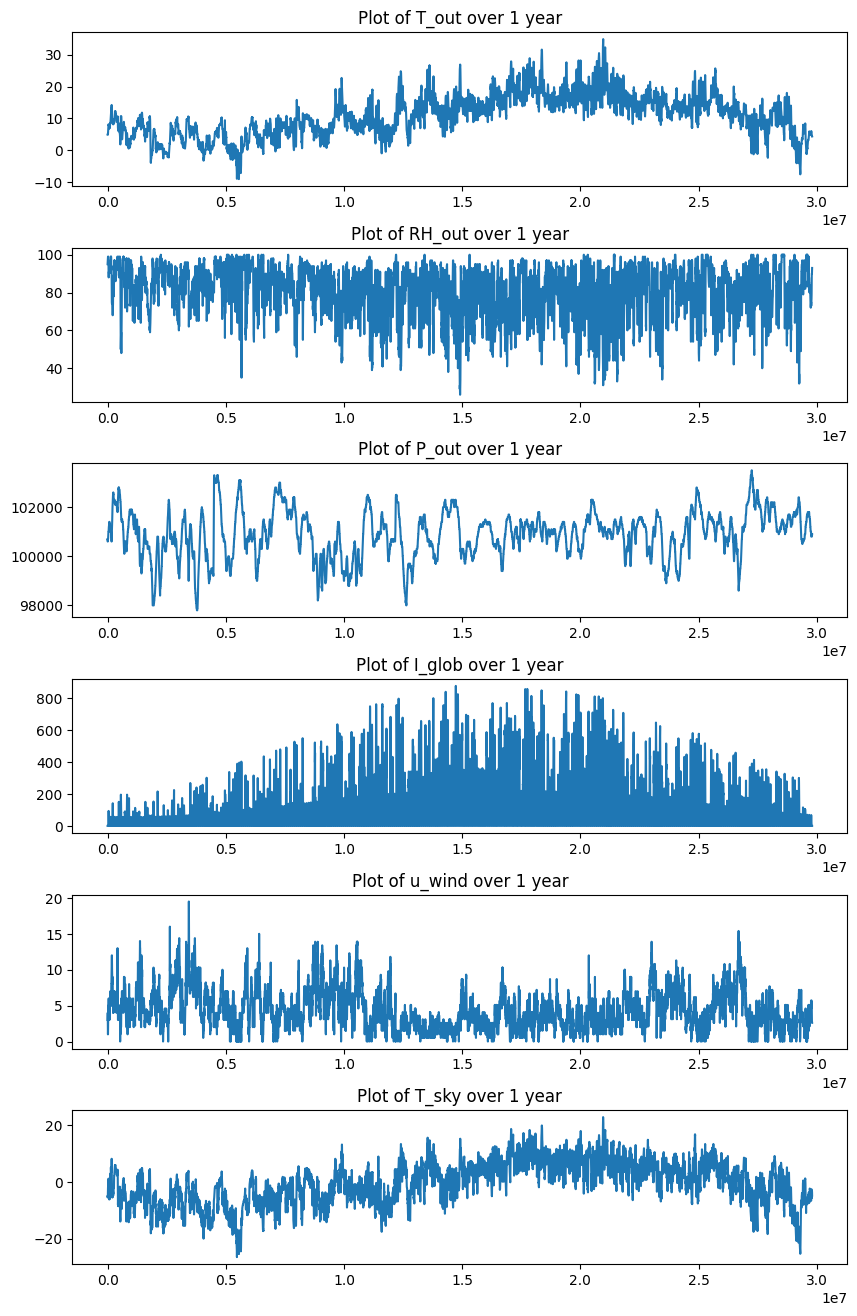

In [6]:
fig, axs = plt.subplots(6,1,figsize=(10,16))
fig.subplots_adjust(wspace=0.4, hspace=0.4)
for i in range(len(old_weather_data.columns.to_list())):
    axs[i].plot(old_weather_data.iloc[:,i])
    
    axs[i].set_title(f'Plot of {old_weather_data.columns[i]} over 1 year')
    
plt.show()

Convert index from DateTime objects to total number of seconds elapsed

In [9]:
start_time = pd.to_datetime(new_weather_data.index)[0]

new_weather_data.index = (pd.to_datetime(new_weather_data.index) - start_time).total_seconds()
new_weather_data = new_weather_data.iloc[::4]
print(new_weather_data)

             I_glob  T_out  P_out  RH_out  u_wind
time                                             
0.0             0.0    1.6   1021     100     4.9
3600.0          0.0    1.7   1020     100     5.2
7200.0          0.0    1.9   1020     100     5.5
10800.0         0.0    2.0   1019     100     5.7
14400.0         0.0    2.5   1018     100     5.6
...             ...    ...    ...     ...     ...
178722000.0   121.4   19.8   1024      54     2.8
178725600.0    98.4   19.6   1023      51     3.3
178729200.0    69.9   19.6   1023      52     3.9
178732800.0    53.2   18.6   1023      57     3.8
178736400.0    15.6   18.5   1023      61     4.2

[49194 rows x 5 columns]


<h2> T_sky </h2>

Sky temperature data based on the relationship learned between outdoor temperature and sky temperature in the old weather dataset. 

In [58]:
from sklearn.ensemble import GradientBoostingRegressor

X = old_weather_data[['T_out']]
y = old_weather_data['T_sky']

SkyTempModel = GradientBoostingRegressor()
SkyTempModel.fit(X, y)

new_weather_data['T_sky'] = SkyTempModel.predict(new_weather_data[['T_out']])

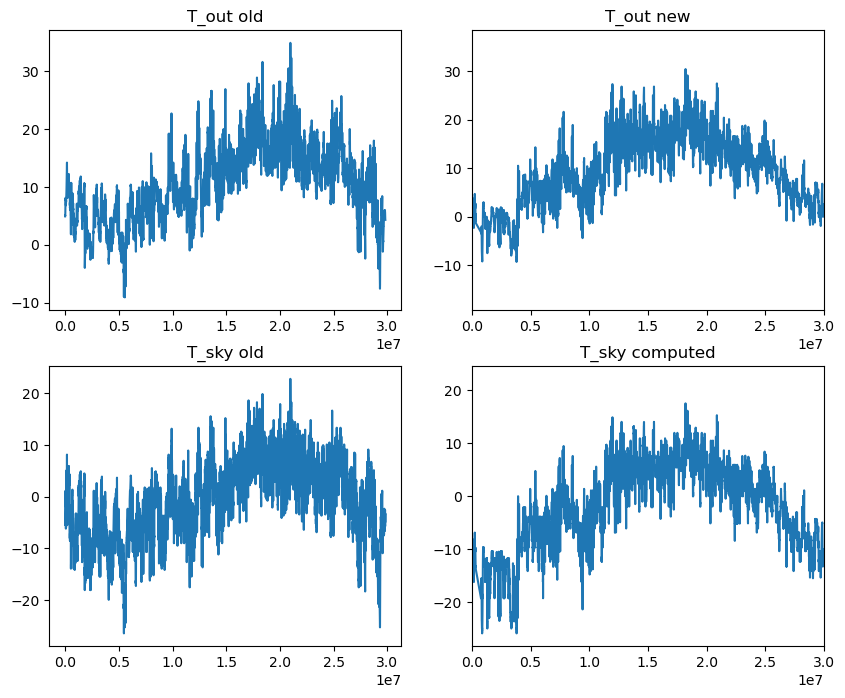

In [59]:
fig, axs = plt.subplots(2,2,figsize=(10,8))
axs[0,0].plot(old_weather_data['T_out'])
axs[1,0].plot(old_weather_data['T_sky'])
axs[0,1].plot(new_weather_data['T_out'])
axs[1,1].plot(new_weather_data['T_sky'])


axs[0,0].set_title('T_out old')
axs[1,0].set_title('T_sky old')
axs[0,1].set_title('T_out new')
axs[1,1].set_title('T_sky computed')

axs[0,1].set_xlim(0,0.3E8)
axs[1,1].set_xlim(0,0.3E8)
plt.show()

<h2> T_air_sp and CO2_air_sp </h2>

The temperature and CO2 concentration set points are determined base on photosynthesis rates at each level of global irradiance. This relationship is derived from the temperature and global irradiance, so it should be possible to learn the pattern of CO2, temperature and illumination set points from the old data and apply that pattern to the new data

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [15]:
print(old_weather_data)

          T_out  RH_out   P_out  I_glob  u_wind     T_sky  T_air_sp  \
time                                                                  
0           4.9      95  100700       0     3.0 -5.031436        16   
3600        5.0      96  100700       0     3.5 -5.031436        16   
7200        5.1      97  100600       0     4.0 -5.490152        16   
10800       5.0      97  100700       0     2.0 -5.031436        16   
14400       5.0      99  100700       0     1.0 -2.327377        16   
...         ...     ...     ...     ...     ...       ...       ...   
29790000    4.5      90  100800       0     4.6 -3.219721        16   
29793600    4.5      90  100900       0     3.1 -3.219721        16   
29797200    4.4      90  100900       0     2.6 -3.444195        16   
29800800    4.3      92  100900       0     2.6 -3.444195        16   
29804400    4.3      93  100900       0     2.6 -4.802958        16   

          CO2_air_sp  ilu_sp  
time                          
0             

In [54]:
seed = 123456

In [55]:
X = old_weather_data.drop(['T_air_sp', 'CO2_air_sp', 'ilu_sp'], axis = 1)

models = {}
performance = {}

for target in ['T_air_sp', 'CO2_air_sp']:
    y = old_weather_data[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    model = RandomForestRegressor(n_estimators=100, random_state=seed)
    model.fit(X_train, y_train)
    
    models[target] = model
    
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    performance[target] = mse
    
    print(f"Model for {target}: MSE = {mse}")

Model for T_air_sp: MSE = 0.09840213365539453
Model for CO2_air_sp: MSE = 283.19806763285027


In [74]:
print(old_weather_data,new_weather_data)

          T_out  RH_out   P_out  I_glob  u_wind     T_sky  T_air_sp  \
time                                                                  
0           4.9      95  100700       0     3.0 -5.031436        16   
3600        5.0      96  100700       0     3.5 -5.031436        16   
7200        5.1      97  100600       0     4.0 -5.490152        16   
10800       5.0      97  100700       0     2.0 -5.031436        16   
14400       5.0      99  100700       0     1.0 -2.327377        16   
...         ...     ...     ...     ...     ...       ...       ...   
29790000    4.5      90  100800       0     4.6 -3.219721        16   
29793600    4.5      90  100900       0     3.1 -3.219721        16   
29797200    4.4      90  100900       0     2.6 -3.444195        16   
29800800    4.3      92  100900       0     2.6 -3.444195        16   
29804400    4.3      93  100900       0     2.6 -4.802958        16   

          CO2_air_sp  ilu_sp  
time                          
0             

In [69]:
for target, model in models.items():
    new_weather_data[target] = model.predict(new_weather_data[['T_out','RH_out','P_out','I_glob','u_wind','T_sky']])

In [75]:
print(new_weather_data)
print(old_weather_data[['T_air_sp', 'CO2_air_sp']].describe())
print(new_weather_data[['T_air_sp', 'CO2_air_sp']].describe())

             I_glob  T_out  P_out  RH_out  u_wind      T_sky  T_air_sp  \
time                                                                     
0.0             0.0    1.6   1021     100     4.9 -10.393654      16.0   
3600.0          0.0    1.7   1020     100     5.2 -10.511957      16.0   
7200.0          0.0    1.9   1020     100     5.5 -10.367882      16.0   
10800.0         0.0    2.0   1019     100     5.7 -10.367882      16.0   
14400.0         0.0    2.5   1018     100     5.6  -9.668551      16.0   
...             ...    ...    ...     ...     ...        ...       ...   
178722000.0   121.4   19.8   1024      54     2.8   8.389920      16.0   
178725600.0    98.4   19.6   1023      51     3.3   8.389920      16.0   
178729200.0    69.9   19.6   1023      52     3.9   8.389920      16.0   
178732800.0    53.2   18.6   1023      57     3.8   7.571603      16.0   
178736400.0    15.6   18.5   1023      61     4.2   7.427941      16.0   

             CO2_air_sp  
time       

<h2>ilu_sp</h2>

Illumination set-point (0, 1) controls whether lighting system should be on or off. Determined based on the level of light outside.

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
pd.options.mode.chained_assignment = None 


X = old_weather_data.drop(['T_air_sp', 'CO2_air_sp', 'ilu_sp'], axis = 1)


data = old_weather_data[['I_glob', 'ilu_sp']]
#data[['ilu_sp_lagged']] = data[['ilu_sp']].shift(1) # attempt at creating a lag feature to try better capture the temporal dependencies between I_glob and ilu_sp
data.fillna(0, inplace=True)

#X = data[['I_glob']] #, 'ilu_sp_lagged']]
y = data['ilu_sp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

IlluminationModel = RandomForestClassifier(random_state = seed)
IlluminationModel.fit(X_train, y_train)

prediction = IlluminationModel.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8325281803542673


In [94]:
print(new_weather_data)

             I_glob  T_out  P_out  RH_out  u_wind      T_sky  T_air_sp  \
time                                                                     
0.0             0.0    1.6   1021     100     4.9 -10.393654      16.0   
3600.0          0.0    1.7   1020     100     5.2 -10.511957      16.0   
7200.0          0.0    1.9   1020     100     5.5 -10.367882      16.0   
10800.0         0.0    2.0   1019     100     5.7 -10.367882      16.0   
14400.0         0.0    2.5   1018     100     5.6  -9.668551      16.0   
...             ...    ...    ...     ...     ...        ...       ...   
178722000.0   121.4   19.8   1024      54     2.8   8.389920      16.0   
178725600.0    98.4   19.6   1023      51     3.3   8.389920      16.0   
178729200.0    69.9   19.6   1023      52     3.9   8.389920      16.0   
178732800.0    53.2   18.6   1023      57     3.8   7.571603      16.0   
178736400.0    15.6   18.5   1023      61     4.2   7.427941      16.0   

             CO2_air_sp  
time       

In [111]:
new_data = new_weather_data.drop(['T_air_sp', 'CO2_air_sp'], axis = 1)
new_weather_data['ilu_sp'] = IlluminationModel.predict(new_data[['T_out','RH_out','P_out','I_glob','u_wind','T_sky']])

In [112]:
print(new_weather_data)

             I_glob  T_out  P_out  RH_out  u_wind      T_sky  T_air_sp  \
time                                                                     
0.0             0.0    1.6   1021     100     4.9 -10.393654      16.0   
3600.0          0.0    1.7   1020     100     5.2 -10.511957      16.0   
7200.0          0.0    1.9   1020     100     5.5 -10.367882      16.0   
10800.0         0.0    2.0   1019     100     5.7 -10.367882      16.0   
14400.0         0.0    2.5   1018     100     5.6  -9.668551      16.0   
...             ...    ...    ...     ...     ...        ...       ...   
178722000.0   121.4   19.8   1024      54     2.8   8.389920      16.0   
178725600.0    98.4   19.6   1023      51     3.3   8.389920      16.0   
178729200.0    69.9   19.6   1023      52     3.9   8.389920      16.0   
178732800.0    53.2   18.6   1023      57     3.8   7.571603      16.0   
178736400.0    15.6   18.5   1023      61     4.2   7.427941      16.0   

             CO2_air_sp  ilu_sp  
tim

<h2> SC_usable </h2>

In [188]:
new_weather_data.to_csv('~/Documents/FYP/data/weatherdata.txt', sep = '\t')
new_weather_data[['T_air_sp','CO2_air_sp']].to_csv('~/Documents/FYP/data/SP_weatherdata.txt', sep = '\t')


In [189]:
old_sc_data = pd.read_csv('../data/old_SC_data.txt', sep='\t', skiprows=2).rename(columns={'0' : 'time'}).set_index('time')
print(old_sc_data)

max_length = old_weather_data.index.max()
modified_old_weather_data = pd.DataFrame(index=test.index)
modified_old_weather_data = modified_old_weather_data.merge(old_weather_data, on='time', how='left')
modified_old_weather_data.fillna(method='bfill', inplace=True)
modified_old_weather_data.fillna(method='ffill', inplace=True)

print(modified_old_weather_data)

          1
time       
1800      1
3600      1
5400      1
7200      1
9000      1
...      ..
29799000  1
29800800  1
29802600  1
29804400  1
29806200  1

[16559 rows x 1 columns]
          T_out  RH_out     P_out  I_glob  u_wind     T_sky  T_air_sp  \
time                                                                    
1800        5.0    96.0  100700.0     0.0     3.5 -5.031436      16.0   
3600        5.0    96.0  100700.0     0.0     3.5 -5.031436      16.0   
5400        5.1    97.0  100600.0     0.0     4.0 -5.490152      16.0   
7200        5.1    97.0  100600.0     0.0     4.0 -5.490152      16.0   
9000        5.0    97.0  100700.0     0.0     2.0 -5.031436      16.0   
...         ...     ...       ...     ...     ...       ...       ...   
29799000    4.3    92.0  100900.0     0.0     2.6 -3.444195      16.0   
29800800    4.3    92.0  100900.0     0.0     2.6 -3.444195      16.0   
29802600    4.3    93.0  100900.0     0.0     2.6 -4.802958      16.0   
29804400    4.3

In [160]:
X = modified_old_weather_data.drop(['T_air_sp', 'CO2_air_sp', 'ilu_sp'], axis = 1)

y = test['1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

SCModel = RandomForestClassifier(random_state = seed)
SCModel.fit(X_train, y_train)

prediction = SCModel.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

print(f"Accuracy: {accuracy}")

Accuracy: 0.960950080515298


In [206]:
modified_new_weather_data = pd.DataFrame(index=[i*1800 for i in range(len(new_weather_data.index)*2)])
modified_new_weather_data.index.names = ['time']
modified_new_weather_data = modified_new_weather_data.merge(new_weather_data, on='time', how='left')
modified_new_weather_data.fillna(method='bfill', inplace=True)
modified_new_weather_data.fillna(method='ffill', inplace=True)

new_sc_data = SCModel.predict(modified_new_weather_data[['T_out','RH_out','P_out','I_glob','u_wind','T_sky']])

new_sc_data = pd.DataFrame(data=new_sc_data, index=modified_new_weather_data.index)
print(new_sc_data)

           0
time        
0          1
1800       1
3600       1
5400       1
7200       1
...       ..
177089400  0
177091200  0
177093000  0
177094800  0
177096600  0

[98388 rows x 1 columns]


In [208]:
print(len(old_weather_data), len(old_sc_data), len(old_weather_data)/(len(old_sc_data)+1))
print(len(new_weather_data), len(new_sc_data), len(new_weather_data)/(len(new_sc_data)))

8280 16559 0.5
49194 98388 0.5


In [209]:
new_sc_data.to_csv('~/Documents/FYP/data/SC_weatherdata.txt', sep = "\t")
